## Randomized Benchmarking
---
**John A. Smolin, David McKay, Yael Ben-Haim and Shelly Garion**


* **Last Updated:** Feb 22, 2019
* **Requires:** qiskit-terra 0.7

This notebook generates sequences for running 2-qubit randomized benchmarking (RB) simulataneous with 1Q RB. 


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

# Import the RB Functions
import qiskit.ignis.randomized_benchmarking as rb

## Select the Parameters of the RB Run

In [17]:
#number of qubits
nQ = 3
#number of seeds (random sequences)
nseeds = 5
#number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)

## Generate RB sequences

We generate RB sequences. We start a small example (so it doesn't take too long to run). In this example we are running 2Q, 1Q simultaneous RB where there are twice as many 1Q Clifford gates.

In [18]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
#2Q RB on Q0,Q2 and 1Q RB on Q1
rb_opts['rb_pattern'] = [[0,2],[1]]
#Do three times as many 1Q Cliffords
rb_opts['length_multiplier'] = [1,3]
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

As an example, we print the circuit corresponding to the first RB sequence

In [19]:
print(rb_circs[0][0])

         ┌───┐               ┌───┐   ┌─────┐             ░      ┌───┐          »
qr_0: |0>┤ H ├───────■───────┤ X ├───┤  Y  ├─────────────░──────┤ Y ├──────────»
         ├───┤┌───┐  │  ┌───┐└─┬─┘ ░ ├─────┤  ░  ┌─────┐ ░ ┌───┐├───┤  ░  ┌───┐»
qr_1: |0>┤ H ├┤ H ├──┼──┤ S ├──┼───░─┤  Y  ├──░──┤ Sdg ├───┤ H ├┤ Z ├──░──┤ H ├»
         ├───┤├───┤┌─┴─┐└───┘  │   ░ ├─────┤┌───┐├─────┤ ░ └───┘├───┤┌───┐├───┤»
qr_2: |0>┤ H ├┤ S ├┤ X ├───────■─────┤ Sdg ├┤ H ├┤  Z  ├─░──────┤ Z ├┤ H ├┤ S ├»
         └───┘└───┘└───┘             └─────┘└───┘└─────┘ ░      └───┘└───┘└───┘»
 cr_0: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
 cr_1: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
 cr_2: 0 ══════════════════════════════════════════════════════════════════════»
                            

## Look at the Unitary for 1 Circuit

Unitary of each RB circuit should be the identity (with a global phase). Simulate using Aer.

In [20]:
#Create a new circuit without the measurement
qc = qiskit.QuantumCircuit(*rb_circs[0][-1].qregs,*rb_circs[0][-1].cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc._attach(i)

In [21]:
backend = qiskit.Aer.get_backend('unitary_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
job = qiskit.execute(qc, backend=backend, basis_gates=basis_gates)
print(np.around(job.result().get_unitary(),3))

[[-0.-1.j  0.+0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -0.-1.j  0.+0.j  0.+0.j  0.+0.j  0.-0.j  0.+0.j  0.+0.j]
 [ 0.-0.j  0.+0.j -0.-1.j  0.+0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j]
 [ 0.+0.j  0.-0.j  0.+0.j -0.-1.j  0.+0.j  0.+0.j -0.-0.j  0.-0.j]
 [-0.+0.j  0.+0.j  0.+0.j  0.+0.j -0.-1.j  0.+0.j  0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -0.-1.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -0.+0.j -0.+0.j  0.-0.j  0.+0.j -0.-1.j  0.-0.j]
 [ 0.+0.j  0.+0.j -0.+0.j  0.+0.j  0.+0.j  0.-0.j -0.+0.j -0.-1.j]]


## Define the noise model

We define a noise model for the simulator. To simulate decay, we add depolarizing error probabilities to the CNOT and U gates.

In [22]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.01
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')
#noise_model = None

## Execute on Aer simulator

In [ ]:
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
basis_gates_str = ','.join(basis_gates)
shots = 1024
result_list = []
qobj_list = []
import time
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    qobj = qiskit.compile(rb_circ_seed, backend=backend, basis_gates=basis_gates_str)
    print('Simulating seed %d'%rb_seed)
    job = backend.run(qobj, noise_model=noise_model, backend_options={'max_parallel_experiments': 0})
    result_list.append(job.result())
    qobj_list.append(qobj)    
print("Finished Simulating")

## Get statistics about the survival probabilities

In [24]:
#create an RBFitter object with 1 seed of data
rbfit = rb.RBFitter([result_list[0]], xdata, shots, rb_opts['rb_pattern'])

### Plot After 1 Seed

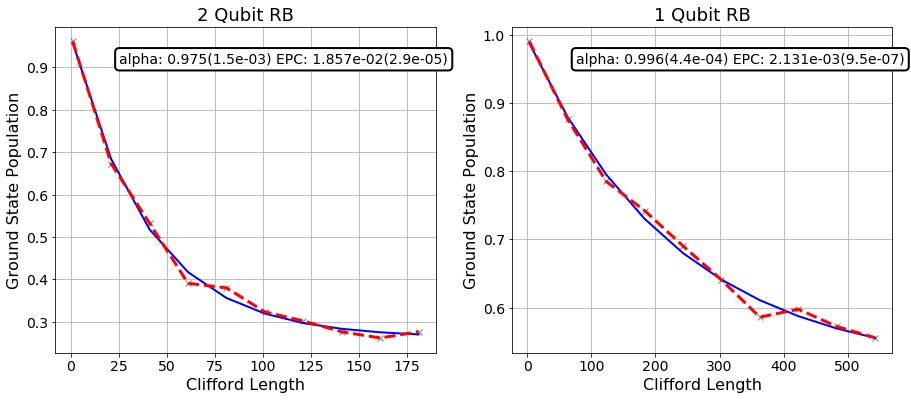

In [25]:
plt.figure(figsize=(15, 6))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    pattern_ind = i

    # Plot the essence by calling plot_rb_data
    rbfit.plot_rb_data(pattern_ind, ax=ax, add_label=True, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit RB'%(len(rb_opts['rb_pattern'][i])), fontsize=18)

plt.show()

In [26]:
#add the rest of the data
rbfit.add_data(result_list[1:])

### Plot with the Rest of the Seeds

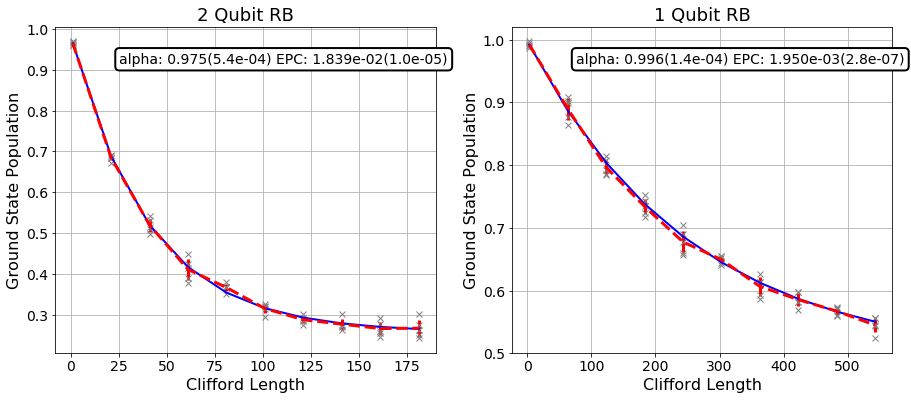

In [27]:
plt.figure(figsize=(15, 6))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    pattern_ind = i

    # Plot the essence by calling plot_rb_data
    rbfit.plot_rb_data(pattern_ind, ax=ax, add_label=True, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit RB'%(len(rb_opts['rb_pattern'][i])), fontsize=18)

plt.show()

### Predicted Gate Fidelity

From the known depolarizing errors on the simulation we can predict the fidelity. First we need to count the number of gates per Clifford.

In [28]:
#Count the number of single and 2Q gates in the 2Q Cliffords
gates_per_cliff = rb.rb_utils.gates_per_clifford(qobj_list,xdata[0],basis_gates,rb_opts['rb_pattern'][0])
for i in range(len(basis_gates)):
    print("Number of %s gates per Clifford: %f"%(basis_gates[i],
                                                 np.mean([gates_per_cliff[0][i],gates_per_cliff[0][i]])))

Number of u1 gates per Clifford: 1.528261
Number of u2 gates per Clifford: 1.782391
Number of u3 gates per Clifford: 0.512609
Number of cx gates per Clifford: 1.507391


In [29]:
#Prepare lists of the number of qubits and the errors
ngates = np.zeros(7)
ngates[0:3] = gates_per_cliff[0][0:3]
ngates[3:6] = gates_per_cliff[1][0:3]
ngates[6] = gates_per_cliff[0][3]
gate_qubits = np.array([0,0,0,1,1,1,-1], dtype=int)
gate_errs = np.zeros(len(gate_qubits))
gate_errs[[1,4]] = p1Q/2 #convert from depolarizing error to epg (1Q)
gate_errs[[2,5]] = 2*p1Q/2 #convert from depolarizing error to epg (1Q)
gate_errs[6] = p2Q*3/4 #convert from depolarizing error to epg (2Q)

#Calc the predicted epc
pred_epc = rb.rb_utils.twoQ_clifford_error(ngates,gate_qubits,gate_errs)
print("Predicted 2Q Error per Clifford: %e"%pred_epc)

Predicted 2Q Error per Clifford: 1.775177e-02


## Run an RB Sequence with T1,T2 Errors

In [30]:
rb_opts2 = rb_opts.copy()
rb_opts2['rb_pattern'] = [[0,1]]
#Do three times as many 1Q Cliffords
rb_opts2['length_multiplier'] = 1
rb_circs2, xdata2 = rb.randomized_benchmarking_seq(**rb_opts2)

noise_model2 = NoiseModel()

#add T1/T2 noise to the simulation
t1 = 100.
t2 = 80.
gate1Q = 0.1
gate2Q = 0.5
noise_model2.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,gate1Q), 'u2')
noise_model2.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,2*gate1Q), 'u3')
noise_model2.add_all_qubit_quantum_error(
    thermal_relaxation_error(t1,t2,gate2Q).kron(thermal_relaxation_error(t1,t2,gate2Q)), 'cx')

In [ ]:
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
basis_gates_str = ','.join(basis_gates)
shots = 1024
result_list2 = []
qobj_list2 = []
for rb_seed,rb_circ_seed in enumerate(rb_circs2):
    print('Compiling seed %d'%rb_seed)
    qobj = qiskit.compile(rb_circ_seed, backend=backend, basis_gates=basis_gates_str)
    print('Simulating seed %d'%rb_seed)
    job = backend.run(qobj, noise_model=noise_model2, backend_options={'max_parallel_experiments': 0})
    result_list2.append(job.result())
    qobj_list2.append(qobj)    
print("Finished Simulating")

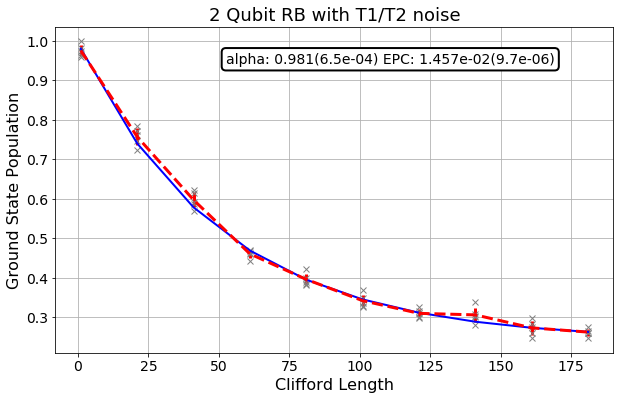

In [32]:
#create an RBFitter object 
rbfit = rb.RBFitter(result_list2, xdata2, shots, rb_opts2['rb_pattern'])

plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the essence by calling plot_rb_data
rbfit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)

# Add title and label
ax.set_title('2 Qubit RB with T1/T2 noise', fontsize=18)

plt.show()

In [33]:
#Count the number of single and 2Q gates in the 2Q Cliffords
gates_per_cliff = rb.rb_utils.gates_per_clifford(qobj_list2,xdata2[0],basis_gates,rb_opts2['rb_pattern'][0])
for i in range(len(basis_gates)):
    print("Number of %s gates per Clifford: %f"%(basis_gates[i],
                                                 np.mean([gates_per_cliff[0][i],gates_per_cliff[0][i]])))

Number of u1 gates per Clifford: 1.493478
Number of u2 gates per Clifford: 1.739130
Number of u3 gates per Clifford: 0.489348
Number of cx gates per Clifford: 1.551522


In [34]:
#Prepare lists of the number of qubits and the errors
ngates = np.zeros(7)
ngates[0:3] = gates_per_cliff[0][0:3]
ngates[3:6] = gates_per_cliff[1][0:3]
ngates[6] = gates_per_cliff[0][3]
gate_qubits = np.array([0,0,0,1,1,1,-1], dtype=int)
gate_errs = np.zeros(len(gate_qubits))

#Here are the predicted primitive gate errors from the coherence limit
gate_errs[[1,4]] = rb.rb_utils.coherence_limit(1,[t1],[t2],gate1Q) 
gate_errs[[2,5]] = rb.rb_utils.coherence_limit(1,[t1],[t2],2*gate1Q) 
gate_errs[6] = rb.rb_utils.coherence_limit(2,[t1,t1],[t2,t2],gate2Q) 

#Calc the predicted epc
pred_epc = rb.rb_utils.twoQ_clifford_error(ngates,gate_qubits,gate_errs)
print("Predicted 2Q Error per Clifford: %e"%pred_epc)

Predicted 2Q Error per Clifford: 1.461375e-02
